## Time-series based analysis of Earthquake Risk Factors

### Part 4: Performing linear regression

Importing the required libraries:

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score




import pickle

### Part 2.1: Prepping Loma Prieta EQ's:

In [2]:
file_path = "../datasets/" + "eq_loma_prieta" + "_clean" + ".csv"

df_lp_eq = pd.read_csv(file_path)
df_lp_eq.drop(columns = "Unnamed: 0", inplace = True)

df_lp_eq["time"] = pd.to_datetime(df_lp_eq["time"])

df_lp_eq.sort_values(by = "time", inplace=True)


df_lp_eq.reset_index(drop = True, inplace=True)
df_lp_eq.drop(columns = ["index", "place", "status", "tsunami", "net", "nst", "type"], inplace=True)

df_lp_eq.head()

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/eq_loma_prieta_clean.csv'

In [ ]:
df_lp_eq.info()

In [ ]:
plt.figure(figsize = (10,7))
im = plt.imread("../assets/Satellite_map_region.png")
implot = plt.imshow(im)



plt.savefig("../plots/Area_map.png")



In [ ]:
ax = plt.gca()


df_lp_eq.plot(kind="scatter", x="longitude", y="latitude",
    s=df_lp_eq['mag']/0.05, label="EQ",
    c=df_lp_eq.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7), ax = ax
)
plt.legend()

plt.tight_layout()

## Finding the main failure time:

In [ ]:
# Source: https://stackoverflow.com/questions/43601868/converting-an-array-datatime-datetime-to-float
import datetime as dt

epoch = dt.datetime(1970, 1, 1)

time = []
for t in [(d - epoch).total_seconds() for d in df_lp_eq["time"]]:
    time.append(float('%.6f' % t))
    
(float(time[0]))

df_lp_eq["time_seconds"] = time

failure_event = df_lp_eq[df_lp_eq["mag"] == df_lp_eq["mag"].max()]

df_lp_eq["time_to_failure_sec"] = np.array(df_lp_eq["time_seconds"]) - np.array(failure_event["time_seconds"])


In [ ]:
df_lp_eq.drop(columns=["time", "time_seconds"], inplace=True)


df_lp_eq.head()

Checking if failure is correctly zero:

In [ ]:
failure_event = df_lp_eq[df_lp_eq["mag"] == df_lp_eq["mag"].max()]

failure_event

In [ ]:
plt.plot(df_lp_eq["time_to_failure_sec"])

# 3D clustering with long-lat-depth

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Standardizing the data:

In [ ]:
#Creating the df for creating the clusters

df_lp_eq_cut = df_lp_eq

df_lp_eq_cut_cut = df_lp_eq_cut.iloc[0:800,:]

df = df_lp_eq_cut_cut[["longitude", "latitude", "depth"]]

ss = StandardScaler()

X_scaled = ss.fit_transform(df)

dbscan = DBSCAN(eps = 0.2, min_samples=5)

dbscan.fit(X_scaled);

df['cluster'] = dbscan.labels_


df_2 = df_lp_eq.copy()

df_2["cluster"] = df["cluster"]


# Getting the top cluster
Top_clusters = df_2.groupby("cluster")["cluster"].count().sort_values(ascending = False)[:3].index


# Plotting the top cluster
if (Top_clusters[0] < 0):
    cluster_mask = Top_clusters[1]
else:
    cluster_mask = Top_clusters[0]
    

ax = plt.gca()
df_selected = df[df["cluster"] == cluster_mask]

df_selected.plot(kind="scatter", x="longitude", y="latitude",
    s=[10] * len(df_selected),
    label="EQ",
    c="black",
    cmap=plt.get_cmap("jet"),
    colorbar=True, 
    alpha=0.4, 
    figsize=(10,7), ax = ax,
    xlim=(-126, -114),
    ylim=(32, 42)
)

plt.legend()

plt.tight_layout()

plt.savefig("../plots/cluster_example.png")


In [ ]:
df_2.groupby("cluster")["cluster"].count().sort_values(ascending = False)

In [ ]:
ax = plt.gca()
df_selected = df[df["cluster"] == cluster_mask]

df_selected.plot(kind="scatter", x="longitude", y="depth",
    s=[10] * len(df_selected),
    label="EQ",
    c="black",
    cmap=plt.get_cmap("jet"),
    colorbar=True, 
    alpha=0.4, 
    figsize=(10,7), ax = ax,
    xlim=(-126, -114),
)

plt.legend()

plt.tight_layout()

plt.savefig("../plots/cluster_example_depth.png")



# Moving clusters design

In [ ]:
data = {"mag_mean": 0, "density": 0, "long_cent": 0, "long_std": 0,
                  "lat_cent": 0, "lat_std": 0, "dept_cent": 0, "dept_std": 0, "time_to_failure": 0}

cluster_df = pd.DataFrame(data, index=[0])



df_lp_eq_cut = df_lp_eq
cnt = 0
ax = plt.gca()
for i in range(40, len(df_lp_eq_cut), 20):

    df_lp_eq_cut_cut = df_lp_eq_cut.iloc[:i,:]

    df = df_lp_eq_cut_cut[["longitude", "latitude", "depth", "mag", "time_to_failure_sec"]]

    ss = StandardScaler()

    X_scaled = ss.fit_transform(df[["longitude", "latitude", "depth"]])

    dbscan = DBSCAN(eps = 0.2, min_samples=5)

    dbscan.fit(X_scaled);

    df['cluster'] = dbscan.labels_


    df_2 = df_lp_eq.copy()

    df_2["cluster"] = df["cluster"]


    # Getting the top cluster
    Top_clusters = df_2.groupby("cluster")["cluster"].count().sort_values(ascending = False)[:3].index


    # Plotting the top cluster
    if (Top_clusters[0] < 0):
        cluster_mask = Top_clusters[1]
    else:
        cluster_mask = Top_clusters[0]

    df_selected = df[df["cluster"] == cluster_mask]   

    
    
    
    df_selected.plot(kind="scatter", x="longitude", y="latitude",
        s=[10] * len(df_selected),
        c="black",
        cmap=plt.get_cmap("jet"),
        alpha=0.4, 
        figsize=(10,7), ax = ax,
        xlim=(-126, -114),
        ylim=(32, 42)
    )

    plt.tight_layout()
    
    plt.savefig(f"../plots/cluster_example{cnt}.png")
    cnt+=1
    


    max_lat = df_selected["latitude"].max()
    min_lat = df_selected["latitude"].min()
    max_long = df_selected["longitude"].max()
    min_long = df_selected["longitude"].min()

    area = (max_lat - min_lat)*(max_long - min_long)
    cluster_density = area / len(df_selected)

    cluster_mag_mean = df_selected["mag"].mean()

    cluster_long_cent = df_selected["longitude"].mean()

    cluster_long_std = df_selected["longitude"].std()

    cluster_lat_cent = df_selected["latitude"].mean()

    cluster_lat_std = df_selected["latitude"].std()

    cluster_dept_cent = df_selected["depth"].mean()

    cluster_dept_std = df_selected["depth"].std()


    cluster_time_to_failure = df_selected["time_to_failure_sec"].iloc[-1]

    rows = [cluster_mag_mean, cluster_density, cluster_long_cent, cluster_long_std,
                      cluster_lat_cent, cluster_lat_std, cluster_dept_cent, cluster_dept_std, cluster_time_to_failure
                      ]


    cluster_df.loc[len(cluster_df)] = rows

cluster_df.drop(cluster_df.index[0], inplace=True)



cluster_df["long_mov"] = cluster_df["long_cent"].diff()
cluster_df["lat_mov"] = cluster_df["long_cent"].diff()

cluster_df.dropna(inplace = True)


cluster_df.reset_index(inplace=True)

cluster_df.drop(columns = "index", inplace=True)





In [ ]:
cluster_df.info()

In [ ]:
cluster_df.head(20)

In [ ]:
import seaborn as sns


df_corr = cluster_df.corr()

#plt.figure(figsize=(6,6))
plt.figure(figsize=(8,6))
sns.heatmap(df_corr[['time_to_failure']].sort_values(by=['time_to_failure'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);
plt.savefig("../plots/EDA_corr_plots.png")

In [ ]:
# Step 3: Instantiate the model
lr = LinearRegression()
# Step 1: Assemble our X and y variables

# We need an X matrix that is n-by-p (in this case, p = 1)
X = cluster_df.drop(columns=["time_to_failure", "long_cent", "lat_cent"])

ss = StandardScaler()

X_scaled = ss.fit_transform(X)

pickle.dump(ss, open('../datasets/ss.pkl', 'wb'))

# We need a y vector that is length n
y = cluster_df["time_to_failure"]

lr.fit(X_scaled, y)

y_pred = lr.predict(X_scaled)


lr.score(X_scaled, y)

In [ ]:
X.head()

In [ ]:
coef_df = pd.DataFrame({'features': list(X.columns), 
              'coef' : list(lr.coef_)})

coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('coef', ascending = False)
coef_df.head(10)

In [ ]:
weights = coef_df['coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(10,7))
plt.barh(labels, weights, color = 'green')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Exp Coef', fontsize=12)
plt.title(f'Top Features - EQ', fontsize=15)
plt.tight_layout()

plt.savefig("../plots/features.png")

In [22]:
cluster_df.head(1)

,mag_mean,density,long_cent,long_std,lat_cent,lat_std,dept_cent,dept_std,time_to_failure,long_mov,lat_mov
0,1.817143,0.000069,-121.698857,0.003696,37.625262,0.018153,5.701857,0.503937,-695607.07,0.049372,0.049372


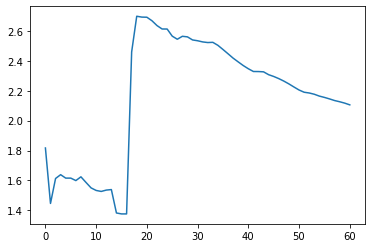

In [23]:
plt.plot(cluster_df["mag_mean"])

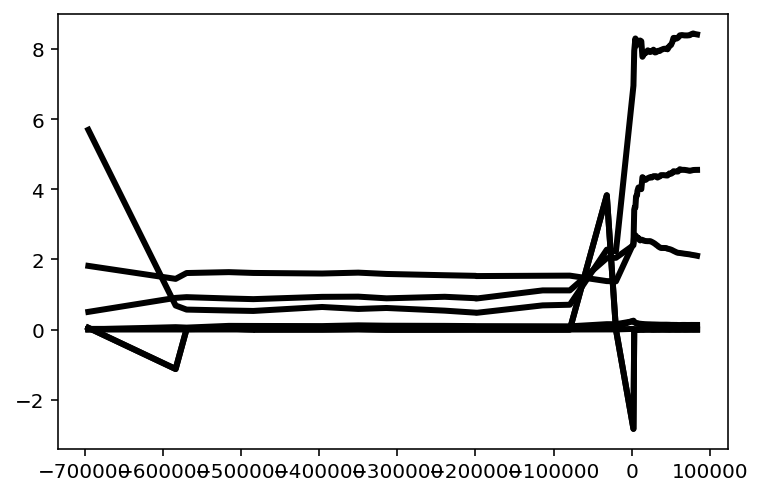

In [24]:
%config InlineBackend.figure_format = 'retina'

columns = list(cluster_df.columns)

columns.remove('time_to_failure')
columns.remove('long_cent')
columns.remove('lat_cent')


color = ["black", "red", "blue", "green", "purple"]


for i, label in enumerate(columns):
    
    plt.plot(cluster_df['time_to_failure'], cluster_df[label], color = "black", linewidth = 3)



In [25]:
print("Hello World!")

Hello World!
